![title](pics/mnist.png)

Loosely based on https://www.kaggle.com/dejavu23/mnist-sklearn-and-keras

# Problem Statement

* **Goal**: We want to create a *deep learning model* that can correctly classify images of *hand-written digits*
  * The model should be able to classify each of the 10 digits, based on small gray-scale images
  * *Classifying* means returning the displayed digit as an integer between 0 and 9
* **Examples**:<br>![digits](pics/digits.png)
* **Challenges**:
  * Assuming a size of $28\times 28$ pixels and 8-bit color resolution, there are $256^{28\cdot 28}$ different images
  * It is difficult to design hand-crafted rules for classifying images, given the amount of variation inherent to handwritings
    * Possibilities: average intensity, topological analysis (number of "holes"), etc.
* **Methods**:
  * We will use (a subset of) the famous [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) for training and evaluating our model
    * Contains 42,000 gray-scale images of size $28\times 28$ pixels
    * Each image is *labelled* with the true digit, i.e., we know which digit is displayed $\rightarrow$ needed for training and evaluating the model
  * We will employ [PyTorch](https://pytorch.org/) as our deep learning framework
    * One of the most popular deep learning frameworks
    * Widely-used, especially in academia
    * Prominent alternative: [TensorFlow](https://www.tensorflow.org/learn)
  * Although digit classification is a comparatively easy problem where even simple models achieve high accuracy, we will investigate ways to further improve accuracy

# Importing the Relevant Packages

(Evaluate code cells by hitting SHIFT+ENTER)

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn import metrics, model_selection

import torch

In [2]:
# display all plots directly in the notebook
%matplotlib inline

Let's have a closer look at the imported packages:
* `numpy` is *the* Python library for efficiently working with (numerical) arrays; note that images are represented as such arrays
* `matplotlib` is a popular plotting library for displaying images and visualizing results
* `sklearn` (aka scikit-learn) is *the* general-purpose library for "classical" (non-deep-learning) ML in Python; contains lots of useful functions, some of which we are going to use here
* `torch` corresponds to PyTorch, our deep learning framework
  * provides `numpy`-like interface to numerical arrays called *tensors*, which in addition to actual values also record gradient information when applying operations to them
  * gradient information can be used to automatically differentiate complicated functions and thereby solve the optimization problems encountered when training neural networks
  * furthermore, seamlessly integrates CUDA for running computations on GPU (not used here)

**Remark**: PyTorch uses [Automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) (AD) to compute gradients. The implementation details are intricate, but the key message is that AD is different from symbolic differentiation found in *Mathematica*, Maple, etc.

# Loading and Inspecting the Data

Images and their labels are stored as Numpy arrays, which we load now:

In [3]:
images = np.load('mnist/imgs.npy')
labels = np.load('mnist/labels.npy')

Let's check the shape of `images` and `labels`:

In [4]:
images.shape

(42000, 1, 28, 28)

In [5]:
labels.shape

(42000,)

The shape of `images` means that there are
* 42,000 images,
* each image has 1 color channel,
* each image has a height of 28 pixels, and
* each image has a width of 28 pixels.

For instance, `images[i, 0, y, x]` refers to the value of pixel $(x, y)$ in the $i$-th image, for $0\leq x,y<28$ and $0\leq i<42000$.

Likewise, the shape of `labels` means that there are 42,000 labels (one for each image, as expected).

Let's visualize some images and print their labels:

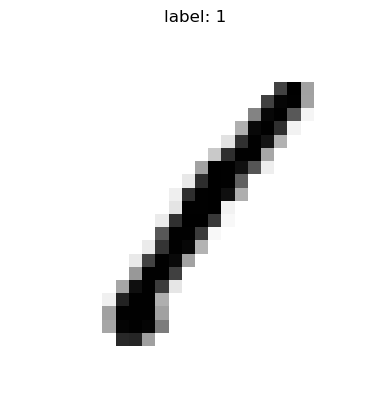

In [6]:
i = 0    # can be any number between 0 and 41999 => Python-indexing is 0-based! (negative indices count from the end)

plt.imshow(images[i, 0], cmap='gray_r')     # select first (and only) color channel from `i`-th image
plt.title('label: ' + str(labels[i]))
plt.axis('off');

**Note**: Colors are reversed, i.e., white has a value of 0 and black has a value of 255, contrary to usual representations. This does not really matter, though, as long as it is consistent in all experiments.

Let's visualize the first 10 images of each class (i.e., digit):

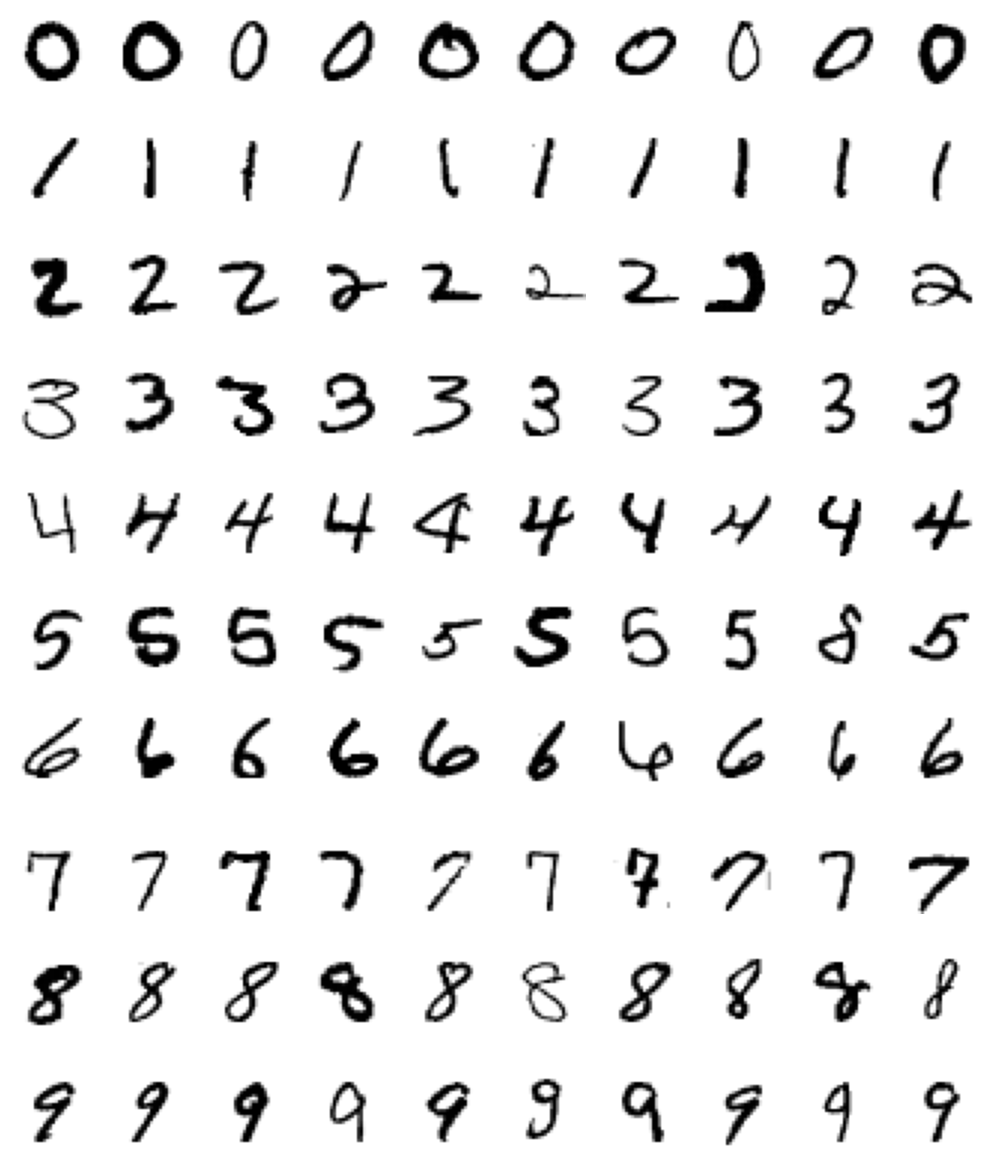

In [7]:
fig, axs = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(10, 12))
axs = axs.flatten()
for i in range(10):
    for k, j in enumerate(np.flatnonzero(labels == i)[:10]):
        axs[10 * i + k].imshow(images[j, 0], cmap='gray_r')
        axs[10 * i + k].axis('off')
plt.tight_layout()

Let's check the number of samples per class:

In [8]:
np.bincount(labels)

array([4132, 4684, 4177, 4351, 4072, 3795, 4137, 4401, 4063, 4188],
      dtype=int64)

# Splitting the Data into Train-, Validation- and Test Sets

We now use one of scikit-learn's convenience functions to split the data into train-, validation- and test sets. More precisely, we set aside 25% for testing, and 20% of the remaining data for validation.

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(images, labels, test_size=0.25, random_state=0)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [7]:
print('Number of training samples:', len(X_train))
print('Number of validation samples:', len(X_val))
print('Number of test samples:', len(X_test))

Number of training samples: 25200
Number of validation samples: 6300
Number of test samples: 10500


**Question**: What's the purpose of partitioning our data into these three sets?

**Question**: We split the data randomly. Are there situations where a completely random split is not feasible?

# Defining PyTorch Datasets and DataLoaders

For training a model in PyTorch, we have to provide our data in a particular way, via DataLoaders. This might be an overkill here, but is very useful in larger developments where images cannot be stored in memory (e.g., due to size constraints) and must be iteratively loaded, preprocessed and passed to the model.

In [8]:
class MNISTDataset(torch.utils.data.Dataset):    # new class MNISTDataset inherits from torch.utils.data.Dataset

    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y

    def __getitem__(self, index: int):
        return self.X[index].astype(np.float32) / 255., self.y[index]

    def __len__(self) -> int:
        return len(self.X)

In [9]:
train_loader = torch.utils.data.DataLoader(MNISTDataset(X_train, y_train), batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(MNISTDataset(X_val, y_val), batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(MNISTDataset(X_test, y_test), batch_size=128, shuffle=False)

**Question**: What does the `batch_size` parameter mean?

Let's inspect the first validation batch:

In [13]:
batch_imgs, batch_labels = next(iter(val_loader))

In [14]:
batch_imgs.shape

torch.Size([128, 1, 28, 28])

In [15]:
batch_labels.shape

torch.Size([128])

In [16]:
batch_labels

tensor([5, 4, 6, 1, 4, 5, 3, 1, 4, 4, 9, 8, 9, 5, 5, 3, 2, 7, 4, 8, 7, 5, 0, 5,
        8, 7, 0, 4, 8, 1, 2, 3, 1, 1, 1, 6, 7, 0, 6, 7, 6, 8, 3, 7, 0, 3, 3, 6,
        9, 8, 0, 0, 5, 5, 9, 1, 1, 3, 7, 1, 8, 8, 0, 0, 1, 2, 7, 8, 5, 0, 1, 2,
        8, 7, 1, 1, 1, 0, 5, 3, 0, 3, 4, 2, 9, 6, 7, 2, 0, 8, 7, 4, 0, 7, 5, 7,
        5, 7, 4, 5, 8, 6, 3, 2, 8, 3, 0, 6, 0, 8, 7, 8, 8, 4, 3, 0, 8, 6, 5, 6,
        0, 5, 4, 8, 6, 3, 6, 8], dtype=torch.uint8)

The images and labels are PyTorch tensors now! They were automatically converted from the corresponding Numpy arrays by the DataLoader.

In [17]:
print('Data type:', batch_imgs.dtype)
print('Maximum:', batch_imgs.max())

Data type: torch.float32
Maximum: tensor(1.)


The data type of the images changed from `uint8` to `float32`, with values in $[0, 1]$, per method `MNISTDataset.__getitem__()` defined above. Input to neural networks should be normalized or standardized, to have values around $0$ - this is beneficial for training.

# Building a Simple PyTorch Model

Let's build a simple *convolutional neural network* (CNN). CNNs constitute the state-of-the-art neural network architecture for image processing. They include *convolution layers*, which apply an affine-linear transformation to all patches of a given size of their input (image). The parameters of the linear transformation (i.e., entries of the corresponding matrix) are learned by training.

![convolution](pics/convolution.gif)

(Taken from https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)

In [10]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, (3, 3), padding='same'),    # convolution with 1 input channel, 32 output channels, kernel size (= patch size) of 3x3
    torch.nn.ReLU(),                                   # ReLU non-linearity, i.e., max(x, 0)
    torch.nn.MaxPool2d(2),                             # max-pooling with kernel size of 2x2 (take maximum of all non-overlapping 2x2 patches)

    torch.nn.Conv2d(32, 32, (3, 3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),

    torch.nn.Flatten(),                                # flatten input to shape (batch_size, 1152)
    
    torch.nn.Linear(1152, 256),                        # affine-linear transformation from 1152 to 256 dimensions
    torch.nn.ReLU(),

    torch.nn.Linear(256, 10)                           # affine-linear transformation from 256 to 10 dimensions
)

`model` is a sequential model, i.e., the layers/operations listed above are applied sequentially. Other, more complicated architectures exist as well (and are typically employed in real-world problems).

**Question**: Why does the last layer return tensors with dimension 10?

Let's inspect the number of parameters of each layer/operation (note that the first entry corresponds to the whole network and is the sum of the other parameters):

In [19]:
for m in model.modules():
    print(m.__class__.__name__ + ':', sum(p.numel() for p in m.parameters()))

Sequential: 307306
Conv2d: 320
ReLU: 0
MaxPool2d: 0
Conv2d: 9248
ReLU: 0
MaxPool2d: 0
Flatten: 0
Linear: 295168
ReLU: 0
Linear: 2570


The network architecture is visualized below. Parentheses show the shape of the output tensor of each layer (w/o batch axis).

![model architecture](pics/mnist_classifier.png)

**Remark**: In principle, neural networks don't need to be composed of dedicated layers, as above. Any combination of "differentiable" PyTorch operations is possible, although it makes sense to primarily use the dedicated layers provided by PyTorch. After all, the only requirement is that the resulting function can be (automatically) differentiated wrt. its parameters.

When constructing a neural network, its parameters are randomly initialized. Therefore, even without any training, we can apply it to input images. We cannot expect any meaningful results, though.

In [11]:
y_hats = []      # initialize empty list
model.eval()     # set model to evaluation mode
with torch.inference_mode():      # set PyTorch to inference mode; this avoids recording gradients, thereby increasing speed
    for data in test_loader:      # iterate over test set, batch-wise
        input, _ = data           # retrieve input images, ignore labels
        y_score = model(input)    # model output with class scores for each input image, tensor of shape (128, 10)
        y_max = torch.argmax(y_score, dim=1).numpy()     # take class with maximum score, convert to Numpy
        y_hats.append(y_max)      # append to list
y_hat = np.concatenate(y_hats)    # concatenate batch-wise results to single array

In [12]:
metrics.accuracy_score(y_test, y_hat)

0.06180952380952381

**Note**: The output returned by the model are no actual probabilities, but arbitrary scores; in particular, they can be negative and do not need to sum to $1$. However, the larger a score (relative to the others), the higher the probability of the corresponding class. Scores can be converted to probabilities by applying the [softmax function](https://en.wikipedia.org/wiki/Softmax_function), but there is no reason to do that.

# Training the Model

Training a neural network model amounts to solving a numerical optimization problem, which is accomplished by gradient descent. PyTorch provides several state-of-the-art numerical optimizers, including the widely-used [Adam](https://arxiv.org/abs/1412.6980):

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

**Question**: What is the meaning of the *learning rate*?

We also need an objective function to minimize, the so-called *loss function*, which maps model predictions and true labels to scalar values. In contrast to the metrics used above, this function must be differentiable, and should be implemented in PyTorch. [Cross-entropy](https://en.wikipedia.org/wiki/Cross-entropy) is frequently used in multiclass classification:

In [23]:
loss_fn = torch.nn.CrossEntropyLoss()

We now define an auxiliary function for training the model for one *epoch*, i.e., one iteration over all training samples. In total, we will train the model for several epochs.

In [24]:
def train_one_epoch():
    # iterate over all batches returned by `train_loader`
    for data in train_loader:
        
        # every data instance is a pair consisting of input images and corresponding labels
        inputs, labels = data

        # set gradients to zero before every optimizer step
        optimizer.zero_grad()

        # apply model to input images
        outputs = model(inputs)

        # compute loss of model predictions and true labels
        loss = loss_fn(outputs, labels)

        # compute gradients of loss wrt. model parameters
        loss.backward()

        # perform optimization step to minimize loss, which (very roughly) amounts to updating parameters as: p_new = p_cur - learning_rate * grad
        optimizer.step()

    # return last loss
    return loss

Now we are set for training the model for a specified number of epochs (which can easily be changed). In every iteration:
* our auxiliary function `train_one_epoch` is called to train the model for one epoch,
* the loss and accuracy of the model on the validation set are computed,
* the training loss, validation loss and validation accuracy are saved in a `history` object, and
* if the validation loss improved, the current parameters are saved; this allows us to load the best model later on.

In [25]:
EPOCHS = 30    # adjust arbitrarily

# initialize best validation loss and training history
best_loss = np.inf
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

# iterate over given number of epochs
for epoch in range(EPOCHS):
    print('EPOCH {}'.format(epoch + 1))

    # set model to training mode (irrelevant here, but good practice in general)
    model.train(True)

    # train for one epoch
    train_loss = train_one_epoch().item()

    # compute validation loss and -accuracy
    running_vloss = 0.0
    running_vacc = 0.0
    model.eval()
    with torch.inference_mode():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vacc += (torch.argmax(voutputs, dim=1) == vlabels).float().mean().item()
            running_vloss += vloss.item()
    val_loss = running_vloss / (i + 1)
    val_acc = running_vacc / (i + 1)
    print('    train loss: {:.4f} | val loss: {:.4f} | val acc: {:.4f}'.format(train_loss, val_loss, val_acc))

    # update history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # save best parameters wrt. validation loss
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'mnist/model_best.pt')

EPOCH 1
    train loss: 0.5553 | val loss: 0.5718 | val acc: 0.8467
EPOCH 2
    train loss: 0.3513 | val loss: 0.3450 | val acc: 0.8988
EPOCH 3
    train loss: 0.3923 | val loss: 0.2758 | val acc: 0.9182
EPOCH 4
    train loss: 0.2122 | val loss: 0.2348 | val acc: 0.9259
EPOCH 5
    train loss: 0.2674 | val loss: 0.2030 | val acc: 0.9390
EPOCH 6
    train loss: 0.1653 | val loss: 0.1776 | val acc: 0.9463
EPOCH 7
    train loss: 0.2024 | val loss: 0.1551 | val acc: 0.9544
EPOCH 8
    train loss: 0.1082 | val loss: 0.1394 | val acc: 0.9583
EPOCH 9
    train loss: 0.0535 | val loss: 0.1232 | val acc: 0.9635
EPOCH 10
    train loss: 0.0882 | val loss: 0.1152 | val acc: 0.9644
EPOCH 11
    train loss: 0.0858 | val loss: 0.1056 | val acc: 0.9671
EPOCH 12
    train loss: 0.0509 | val loss: 0.0999 | val acc: 0.9691
EPOCH 13
    train loss: 0.0771 | val loss: 0.0901 | val acc: 0.9706
EPOCH 14
    train loss: 0.0883 | val loss: 0.0875 | val acc: 0.9710
EPOCH 15
    train loss: 0.1236 | val loss:

Save/load the training history:

In [35]:
#pickle.dump(history, open('mnist/training_history_augmentation.pkl', mode='wb'))

In [29]:
#history = pickle.load(open('mnist/training_history_pretrained.pkl', mode='rb'))

Plot the training history, in particular the validation accuracy:

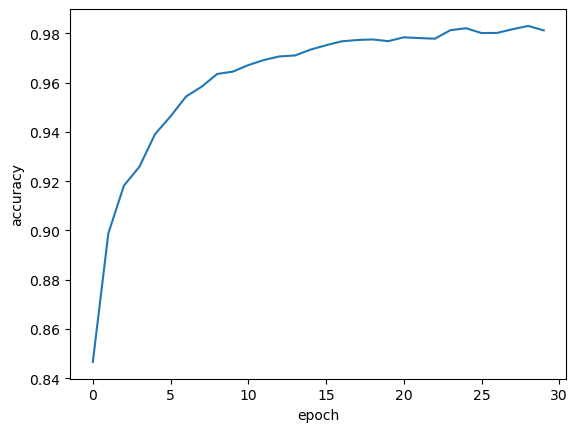

In [26]:
plt.plot(history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy');

# Evaluating the Model

Validation accuracy should not be used to assess the predictive quality of a model. Instead, the model should be evaluated on a completely independent test set.

**Question**: Why?

Let's load the best parameters, i.e., the parameters where the validation loss during training was minimal. Alternatively, you can also try `"mnist/model_pretrained.pt"`, with pre-trained parameters:

In [13]:
model.load_state_dict(torch.load('mnist/model_best.pt'))     # either "model_pretrained.pt" or "model_best.pt"

<All keys matched successfully>

Evaluate the model on the test set:

In [14]:
# same as above
y_hats = []
model.eval()
with torch.inference_mode():
    for data in test_loader:
        input, _ = data
        y_score = model(input)
        y_max = torch.argmax(y_score, dim=1).numpy()
        y_hats.append(y_max)
y_hat = np.concatenate(y_hats)

In [15]:
metrics.accuracy_score(y_test, y_hat)

0.9834285714285714

In addition to simple scalar values, we can also evaluate predictive performance more comprehensively, e.g., through a *confusion matrix*:

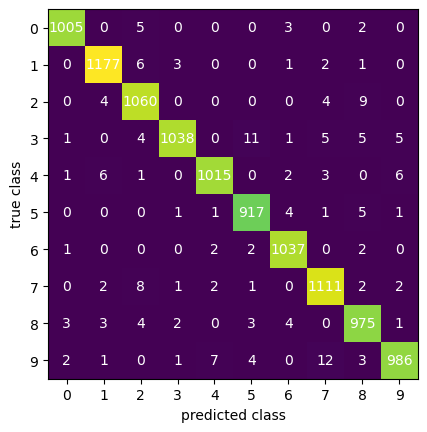

In [30]:
matrix = metrics.confusion_matrix(y_test, y_hat)
plt.imshow(matrix)
for i in range(len(matrix)):
    for j in range(len(matrix)):
        text = plt.gca().text(j, i, matrix[i, j], ha='center', va='center', color='w')
plt.xticks(np.arange(len(matrix)))
plt.yticks(np.arange(len(matrix)))
plt.xlabel('predicted class')
plt.ylabel('true class');

**Question**: What does the confusion matrix tell us?

Extract the indices of all wrongly classified samples in the test set:

In [28]:
wrong_idx = np.flatnonzero(y_hat != y_test)    # `np.flatnonzero()` returns the indices of all True elements in a boolean array
len(wrong_idx)

179

Inspect wrong predictions:

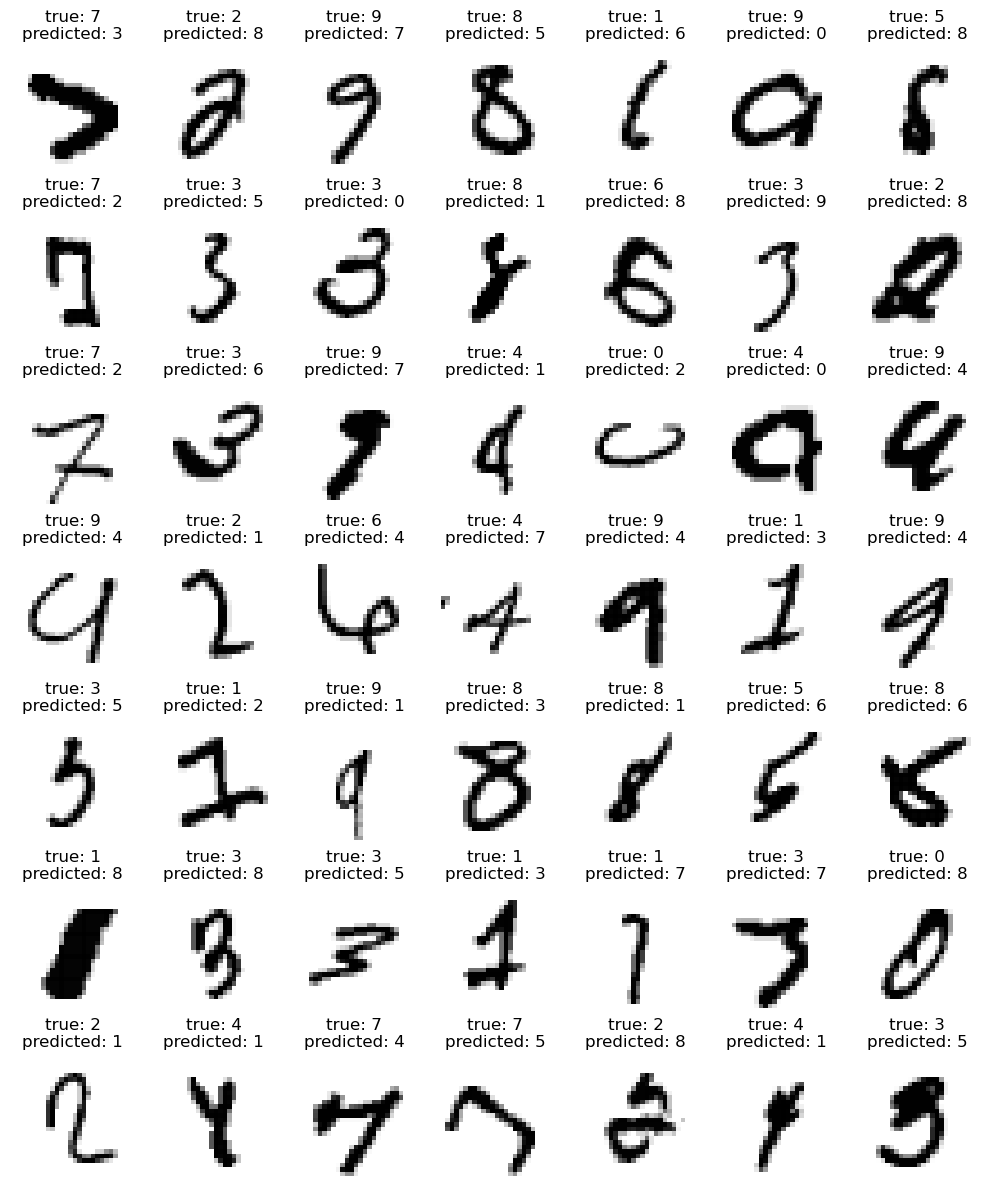

In [29]:
fig, axs = plt.subplots(7, 7, sharex=True, sharey=True, figsize=(10, 12))
axs = axs.flatten()
for i, j in zip(range(len(axs)), wrong_idx):
    axs[i].imshow(X_test[j, 0], cmap='gray_r')
    axs[i].set_title('true: {}\npredicted: {}'.format(y_test[j], y_hat[j]))
    axs[i].axis('off')
plt.tight_layout()

# Live Classification of Handwritten Digits

Let's play around and have the model classify our own handwriting! This little app is implemented in a separate Python file, which we simply import now:

In [17]:
import mnist

Evaluate the following command and draw digits (or whatever you like) in the white box. Right-click to clear.

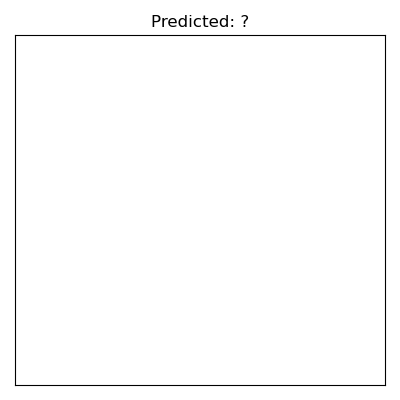

In [72]:
# needed for interactive Matplotlib figures
%matplotlib widget

canvas = mnist.canvas(model)

In [73]:
# close interactive plot to release resources
plt.close()

**Question**: What happens if you draw other symbols, like letters? Why?

# Improving the Classification Model

**Question**: What can we do to further increase classification accuracy?

## Possible Answers

### "Obvious" Approaches

* Train the model for more epochs. However, be aware that the model may start to [overfit](https://en.wikipedia.org/wiki/Overfitting) at some point, i.e., the training loss keeps decreasing, but the validation loss starts to increase. **In other words, the model learns the training set by heart and fails to generalize to unseen data.**
* Collect more training data. The more data, the better, but be aware that the data used for training the model should as closely as possible match the data the model will be applied to afterward. **In other words, training- and test data should be drawn from the same distribution.**
* Change the network architecture, possibly increasing the number of trainable parameters and/or adding regularization. More parameters lead to more expressive models that tend to overfit sooner, whereas regularization (e.g., [batch normalization](https://en.wikipedia.org/wiki/Batch_normalization), [dropout](https://en.wikipedia.org/wiki/Dilution_(neural_networks)), [weight decay](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab)) helps to reduce overfitting.

### Ensembling

*Ensembling* means training several independent models, applying all of them to a given input, and combining their individual outputs to obtain the final prediction. This leads to an improvement of predictive performance in many cases.

The individual models can be trained in many different ways, including:
* training the same neural network architecture on the same data, relying on randomness inherent to the training process (e.g., parameter initialization, order of training samples, stochastic network layers [e.g., Dropout]),
* training each model on a different subset of the training data,
* using different optimizers,
* using different neural network architectures,
* using completely different ML algorithms, like neural networks, random forests, support vector machines, etc.

Likewise, the individual outputs can be combined in several ways, including:
* averaging scores or probabilities and returning the most probable class after averaging,
* returning the class predicted by most models ("voting").

**This is a straightforward technique to improve predictive performance. You can easily try it yourself.**

### Data Augmentation

Data augmentation is one of the most widely used techniques to improve image classification models. It is based on the following key idea: **Slightly modifying an image, e.g., by rotating, resizing, cropping, etc., does not change the class label.** So, by modifying our training images, we can **massively increase** the size of our training set **for free.**

Here, we will restrict ourselves to rotations, but you can easily try out other augmentation techniques yourself. For instance, the [imgaug](https://imgaug.readthedocs.io/en/latest/) and [torchvision](https://pytorch.org/vision/stable/transforms.html) Python packages implement lots of ready-to-use augmentations and can easily be installed.

Import a function to rotate images by arbitrary angles:

In [25]:
from scipy.ndimage import rotate

Let's try it out on an image:

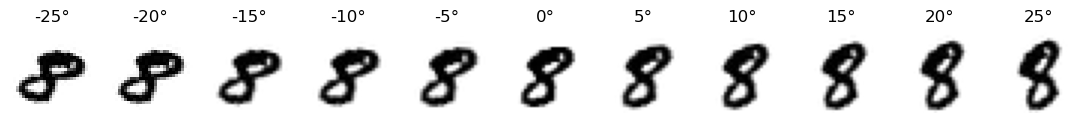

In [26]:
%matplotlib inline

img_idx = 10   # index of image to rotate, within `images`

fig, axs = plt.subplots(1, 11, sharex=True, sharey=True, figsize=(11, 3))
axs = axs.flatten()
for i, angle in enumerate([-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25]):
    img = rotate(images[img_idx], angle, axes=(1, 2), reshape=False)     # axes=(1, 2), because axes 1 and 2 correspond to spatial dimensions
    axs[i].imshow(img[0], cmap='gray_r')
    axs[i].axis('off')
    axs[i].set_title('{}°'.format(angle))
plt.tight_layout()

The easiest way to incorporate augmentation into our model-training workflow is via the `MNISTDataset` class defined above. We simply need to redefine the `__getitem__` method of that class:

In [30]:
class MNISTAugmentedDataset(MNISTDataset):

    def __init__(self, X: np.ndarray, y: np.ndarray, max_angle: float = 25.):
        super(MNISTAugmentedDataset, self).__init__(X, y)
        self.max_angle = max_angle

    def __getitem__(self, index: int):
        img, lbl = super(MNISTAugmentedDataset, self).__getitem__(index)

        # img is a float-array of shape (1, 28, 28), with values in [0, 1] interval, and lbl is its class label

        # only rotate if max_angle is positive => allows to disable augmentation
        if self.max_angle > 0:
            # choose random number, uniformly distributed between -max_angle and max_angle
            # note: we could seed the random number generator to obtain reproducible results
            angle = np.random.uniform(-self.max_angle, self.max_angle)
            
            img = rotate(img, angle, axes=(1, 2), reshape=False)
            np.clip(img, 0, 1, out=img)    # clip to [0, 1] interval

        return img, lbl

Update the `train_loader`. We do not want to augment validation- and test images here, so there is no need to update `val_loader` and `test_loader`.

In [31]:
train_loader = torch.utils.data.DataLoader(MNISTAugmentedDataset(X_train, y_train, max_angle=25), batch_size=128, shuffle=True)

The rest proceeds as above, literally without changes. Only note that since the training data changes in every epoch due to data augmentation, we should be able to train for more epochs without overfitting.

**Question**: Would it make sense to augment the validation- and test images as well?

# Summary

We followed these **general steps** to obtain an accurate image classification model:
1. Collect a sufficient amount of *labeled* data.
   * "Sufficient" depends a lot on the data modality, number of classes and problem difficulty.
   * Labels are important; however, there exist strategies for training models without explicitly provided labels, too, so-called *self-supervised learning*.
2. Thoroughly analyze data to identify potential biases.
   * Okay, we didn't analyze our data very thoroughly, because MNIST is a well-established dataset.
   * If we had collected the data ourselves, this step would be extremely important, though! Bias can be **everywhere** and is easily overlooked.
3. Define non-overlapping training, validation and test sets.
   * Final predictive performance should only be assessed on the test set, which must not be used for model training at all.
   * If only few data are available, more data-efficient splitting strategies exist as well, e.g., $k$-fold cross validation.
4. Define a suitable neural network architecture.
   * "Suitable" depends a lot on the specific use-case.
   * Convolutional neural networks still represent the state-of-the-art in computer vision.
5. Train the model on the training set.
   * Use the validation set to monitor the training progress and detect overfitting.
   * Consider employing data augmentation to artificially increase the training set.
6. Thoroughly evaluate the final model on the test set.
   * Calculate different performance metrics and investigate failure cases.
7. Go back to step 1 if model performance is not sufficient.
   * Also, consider techniques such as ensembling to improve performance.